In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset and check general information

In [3]:
df = pd.read_csv('claims_sample_data.csv')

In [4]:
# check dataset information, pay attention to count of null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [5]:
# preview dataset
df.head(3)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937


In [6]:
# check for duplicates
df.duplicated().sum() # no duplicates

0

# explore 'MONTH' column

In [8]:
df['MONTH'].value_counts()

MONTH
201907    1877
201910    1863
201908    1828
201905    1823
201901    1790
202001    1782
201808    1775
201909    1774
201912    1772
202003    1769
201903    1769
201904    1767
201809    1767
201805    1759
201902    1751
201810    1748
201811    1747
201906    1746
201806    1745
201911    1723
201803    1723
201812    1718
201804    1714
201801    1712
202002    1711
201807    1706
202005    1668
201802    1664
202004    1539
202006    1344
202007      67
201900      11
Name: count, dtype: int64

In [9]:
# replace non valid date by closest date
df['MONTH'] = df['MONTH'].astype(str)
df['MONTH'] = df['MONTH'].str.replace('201900', '201901')

In [10]:
# convert to datetime
df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y%m')

In [11]:
# explore 'SERVICE_CATEGORY' column
df.SERVICE_CATEGORY.value_counts()

SERVICE_CATEGORY
SpecialistsFFS        12296
AncillaryFFS           9701
InpatientServices      9424
OutpatientServices     7582
ERServices             3696
ASCServices            2643
SNFServices            2501
SpecialistFFS          1684
PCPFFS                 1403
PCPEncounter           1222
Name: count, dtype: int64

# Explore 'CLAIM_SPECIALTY' column

In [13]:
df['CLAIM_SPECIALTY'].isna().sum()

251

In [14]:
df['CLAIM_SPECIALTY'].value_counts()

CLAIM_SPECIALTY
INTERNAL MEDICINE                   1227
FAMILY PRACTICE                     1128
GENERAL PRACTICE                     949
GENERAL SURGERY                      806
PATHOLOGY                            772
                                    ... 
PSYNUR                                 1
Physician/Ophthalmology                1
Registered Nurse First Assistant       1
PHGPM                                  1
NPAGRT                                 1
Name: count, Length: 905, dtype: int64

##### Summary: missing values and too much unique records (905), let's preprocess 'CLAIM_SPECIALTY' column

In [16]:
# fill missing values by Other
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].fillna('Other')

In [17]:
# remove non letters, exra spaces, and apply Camel case
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].apply(lambda x: ' '.join(x.split()))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].apply(lambda x: x[0].upper() + x[1:].lower())

In [18]:
df['CLAIM_SPECIALTY'].value_counts()

CLAIM_SPECIALTY
Internal medicine                      1730
Family practice                        1512
Radiology                              1164
General practice                       1132
Gastroenterology                       1097
                                       ... 
Certified clinical nurse specialist       1
Laryngology                               1
Surgery transplant                        1
Pediatric nurse practitioner              1
Npagrt                                    1
Name: count, Length: 768, dtype: int64

##### Summary: missing values filled, number of unique records was reduced (from 905 to 768).
##### Possible next step: group values based on cosinus similarity (out of scope of current analysis)

In [20]:
df.isna().any() 
# no missing values in whole dataset

MONTH               False
SERVICE_CATEGORY    False
CLAIM_SPECIALTY     False
PAYER               False
PAID_AMOUNT         False
dtype: bool

# explore 'PAYER' column

In [22]:
df.PAYER.value_counts()

PAYER
Payer F     9020
Payer CA    8681
Payer W     7105
Payer UN    6526
Payer O     6278
Payer S     4189
Payer CO    3677
Payer B     3631
Payer H     2360
Payer UL     685
Name: count, dtype: int64

# Explore 'PAID_AMOUNT' column

In [24]:
# check for ranges of values in 'PAID_AMOUNT' column
pd.qcut(df.PAID_AMOUNT.sort_values(), 16).drop_duplicates()

24512      (-42230.001, 0.0]
1904             (0.0, 59.0]
72             (59.0, 123.0]
1814          (123.0, 194.0]
3182          (194.0, 293.0]
28491         (293.0, 384.0]
41602         (384.0, 473.0]
41090         (473.0, 586.0]
35266         (586.0, 730.0]
18064         (730.0, 913.0]
36729        (913.0, 1151.0]
18386       (1151.0, 1465.0]
44759       (1465.0, 1887.0]
33531       (1887.0, 2477.0]
14266       (2477.0, 6586.5]
4341     (6586.5, 2268611.0]
Name: PAID_AMOUNT, dtype: category
Categories (16, interval[float64, right]): [(-42230.001, 0.0] < (0.0, 59.0] < (59.0, 123.0] < (123.0, 194.0] ... (1465.0, 1887.0] < (1887.0, 2477.0] < (2477.0, 6586.5] < (6586.5, 2268611.0]]

__Conclusion: dataset contains negative values (most likely refunds), zero values (most likely free services), very huge values__

In [26]:
# let's mark free and refund values
df['refund'] = (df.PAID_AMOUNT < 0)
df['free'] = (df.PAID_AMOUNT == 0)

## explore Zero values

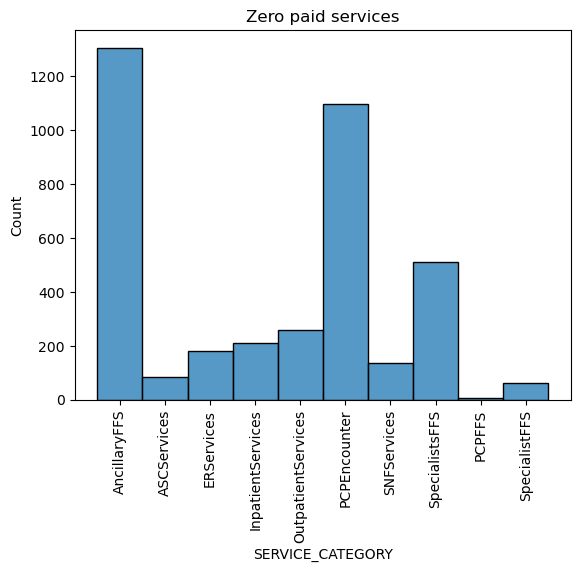

In [28]:
sns.histplot(data=df[df['free']], x='SERVICE_CATEGORY')
plt.xticks(rotation=90)
plt.title('Zero paid services')
plt.show()

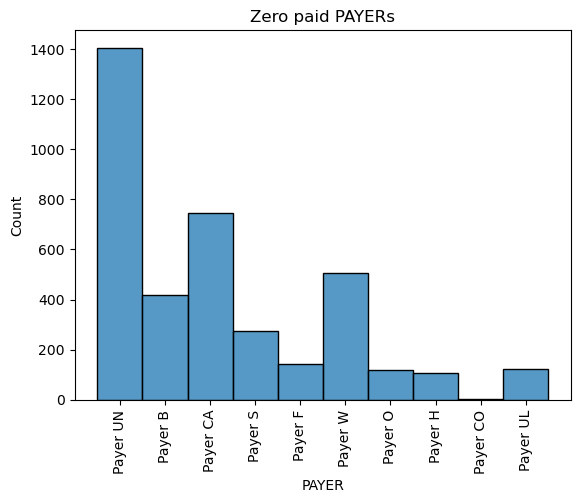

In [29]:
sns.histplot(data=df[df['free']], x='PAYER')
plt.xticks(rotation=90)
plt.title('Zero paid PAYERs')
plt.show()

## Explore negative values

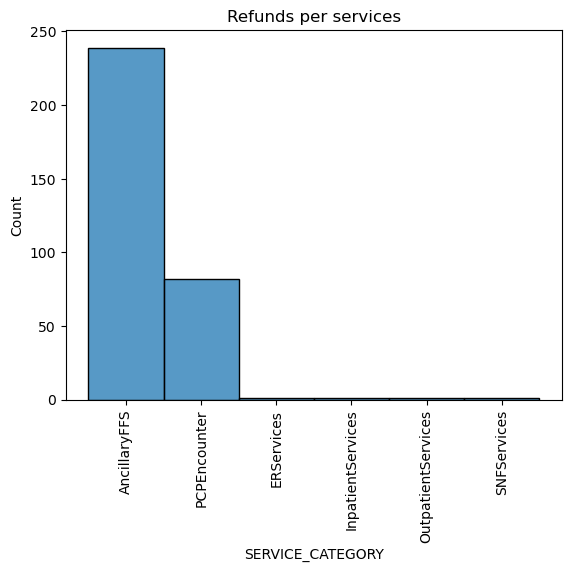

In [31]:
sns.histplot(data=df[df['refund']], x='SERVICE_CATEGORY')
plt.xticks(rotation=90)
plt.title('Refunds per services')
plt.show()

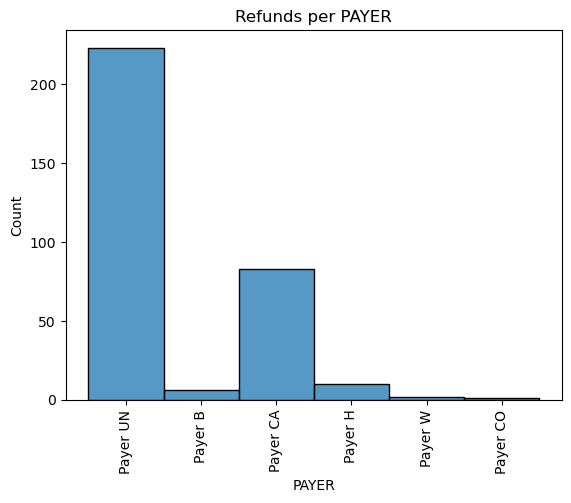

In [32]:
sns.histplot(data=df[df['refund']], x='PAYER')
plt.xticks(rotation=90)
plt.title('Refunds per PAYER')
plt.show()

#### Futher analisys can done either with zero and negative values, either without them, depending on requirements
#### Let's remove records with zero and negative paid amount

In [34]:
df = df[(df['refund'] == False) & (df['free'] == False)].reset_index(drop=True)

## Looking for outliers

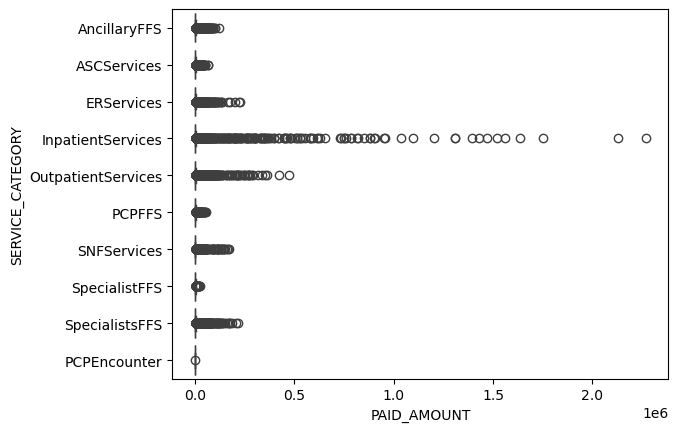

In [36]:
# check boxplot per categories
sns.boxplot(data = df,
           x = 'PAID_AMOUNT',
           y = 'SERVICE_CATEGORY')
plt.show()

In [37]:
df.loc[df['MONTH'].dt.month.isin([1,2,12]),'season'] = 'winter'
df.loc[df['MONTH'].dt.month.isin([3,4,5]),'season'] = 'spring'
df.loc[df['MONTH'].dt.month.isin([6,7,8]),'season'] = 'summer'
df.loc[df['MONTH'].dt.month.isin([9,10,11]),'season'] = 'autumn'

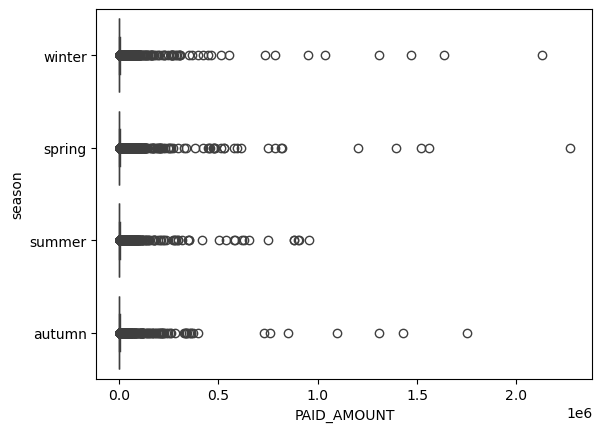

In [38]:
# check for outliers per season
sns.boxplot(data = df,
           x = 'PAID_AMOUNT',
           y = 'season')
plt.show()

In [39]:
# below steps required to find outliers in dataset
iqr = df['PAID_AMOUNT'].quantile(0.75) - df['PAID_AMOUNT'].quantile(0.25)

In [40]:
low_border = df['PAID_AMOUNT'].quantile(0.25) - iqr*1.5
upper_border = df['PAID_AMOUNT'].quantile(0.75) + iqr*1.5
print(low_border, upper_border)

-1671.0 3553.0


In [41]:
(df['PAID_AMOUNT'] < low_border).sum()
# no outliers on the left

0

In [42]:
(df['PAID_AMOUNT'] > upper_border).sum()
# 5125 outliers on the right

5125

## Explore outliers through services, payers

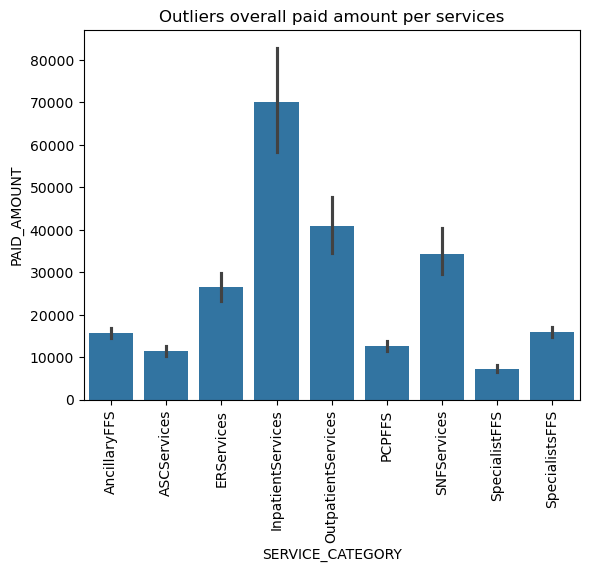

In [44]:
sns.barplot(data=df[df['PAID_AMOUNT'] > upper_border], x='SERVICE_CATEGORY', y="PAID_AMOUNT")
plt.xticks(rotation=90)
plt.title('Outliers overall paid amount per services')
plt.show()

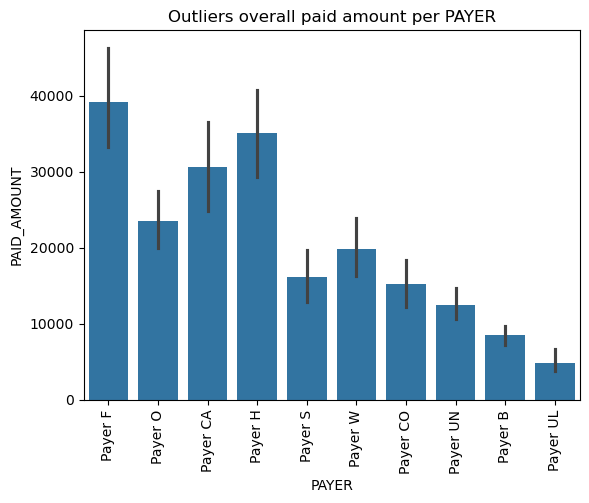

In [45]:
sns.barplot(data=df[df['PAID_AMOUNT'] > upper_border], x='PAYER', y="PAID_AMOUNT")
plt.xticks(rotation=90)
plt.title('Outliers overall paid amount per PAYER')
plt.show()

In [46]:
total_paid_outliers = df[df['PAID_AMOUNT'] > upper_border]['PAID_AMOUNT'].sum()
total_paid = df['PAID_AMOUNT'].sum()
print("Paiments for outliers took " + str((total_paid_outliers*100 / total_paid).round(2)) + " % of total payments")

Paiments for outliers took 82.0 % of total payments


## Explore data through months, seasons

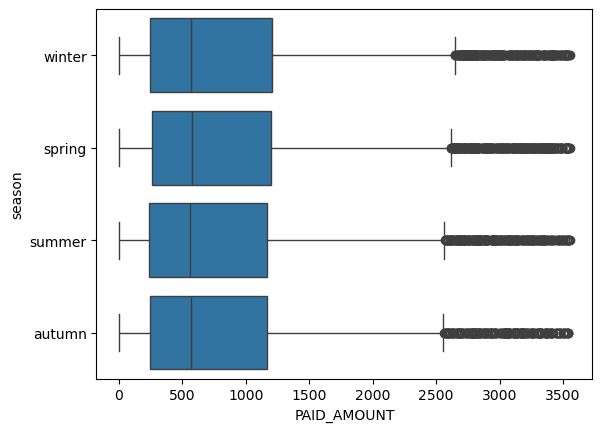

In [48]:
# check boxplot per season for data without outliers
sns.boxplot(data = df[df['PAID_AMOUNT'] <= upper_border],
           x = 'PAID_AMOUNT',
           y = 'season')
plt.show()

In [49]:
df['month_name'] = df['MONTH'].dt.month_name()

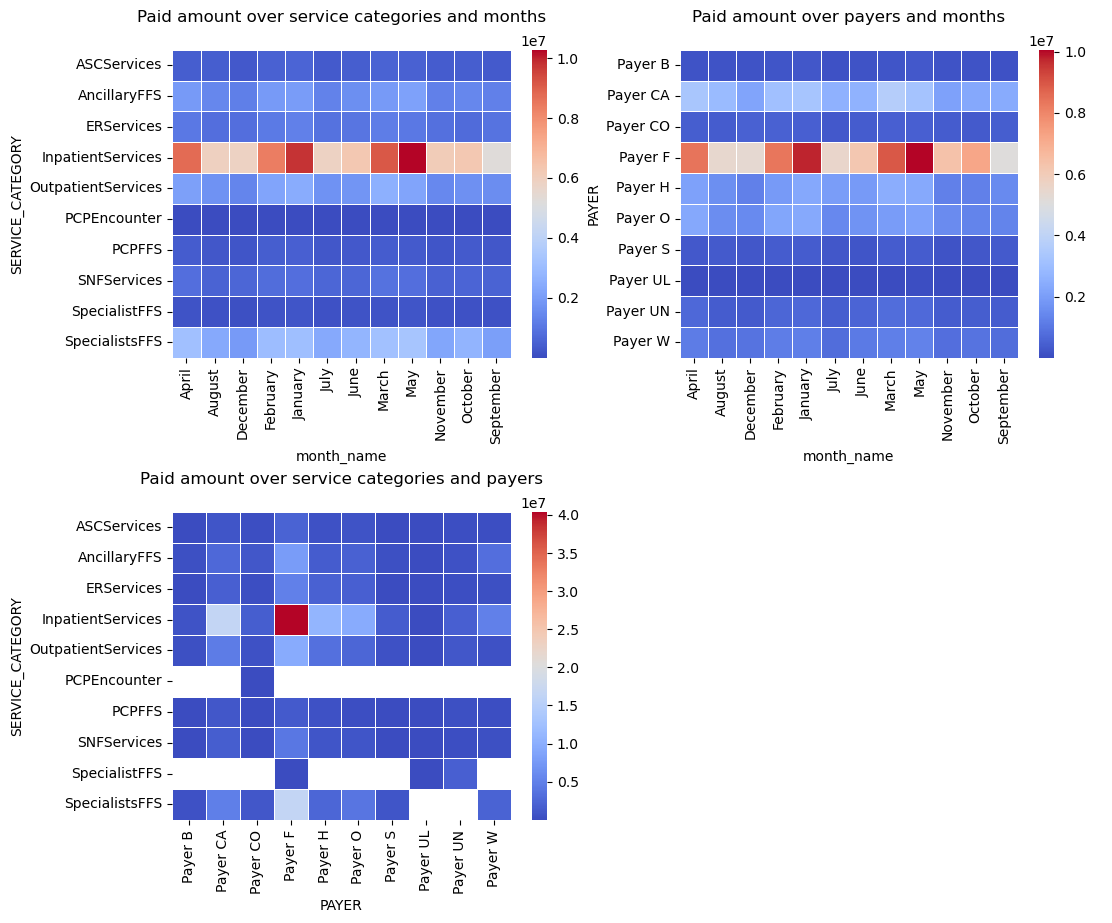

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
sns.heatmap(df.groupby(['month_name', 'SERVICE_CATEGORY'])['PAID_AMOUNT'].sum().unstack('month_name'),
           cmap = 'coolwarm',
           linewidth = 0.5, ax = ax1)
sns.heatmap(df.groupby(['month_name', 'PAYER'])['PAID_AMOUNT'].sum().unstack('month_name'),
           cmap = 'coolwarm',
           linewidth = 0.5, ax = ax2)
sns.heatmap(df.groupby(['PAYER', 'SERVICE_CATEGORY'])['PAID_AMOUNT'].sum().unstack('PAYER'),
           cmap = 'coolwarm',
           linewidth = 0.5, ax = ax3)

ax1.set_title('Paid amount over service categories and months', pad=20)
ax2.set_title('Paid amount over payers and months', pad=20)
ax3.set_title('Paid amount over service categories and payers', pad=20)
ax4.axis('off') 

plt.subplots_adjust(hspace=0.5)

plt.show()

In [89]:
df.to_pickle('df.pkl')

#### to be continued in eda_part2.ipynb